In [1]:
!pip install pytorch-metric-learning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from torchvision import models
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda import amp
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_metric_learning import losses
import math

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
INPUT_SIZE = (224, 224)
data_transform = A.Compose([A.Resize(INPUT_SIZE[0], INPUT_SIZE[1]),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate(limit=45, p=1.0),
                        A.CoarseDropout(
                                    max_holes=8,                
                                    max_height=16,              
                                    max_width=16,               
                                    min_holes=1,                
                                    min_height=8,               
                                    min_width=8,                
                                    fill_value=0,               
                                    p=0.5                        
                                ),
                        A.RandomBrightnessContrast(
                                brightness_limit=(-0.1,0.1), 
                                contrast_limit=(-0.1, 0.1), 
                                p=0.5),
                        A.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225], 
                                max_pixel_value=255.0, 
                                p=1.0),
                        ToTensorV2()], p=1.)

/tmp/ipykernel_18/515749218.py:6: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [5]:
class DATA(Dataset):
    def __init__(self, path, transform=None, phase="train"):
        self.path = path
        self.phase = phase
        self.transform = transform
        
        folders = os.listdir(path)
        self.image_paths = []  # ❌ Chỉ lưu đường dẫn, không load ảnh
        self.labels = []
        
        self.label_dict = {}
        for i, value in enumerate(folders):
            self.label_dict[value] = i
        print(self.label_dict)
        
        for image_folder in folders:
            items_path = os.path.join(self.path, image_folder)
            items_list = os.listdir(items_path)
            
            for image_name in items_list:
                image_path = os.path.join(items_path, image_name)
                self.image_paths.append(image_path)  # ✅ Chỉ lưu path
                self.labels.append(self.label_dict[image_folder])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # ✅ Load ảnh khi cần thiết
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.labels[idx]
        
        if self.phase == "train":
            if self.transform:
                image = self.transform(image=image)["image"]
            return image, torch.tensor(label, dtype=torch.float32)
        else:
            if self.transform:
                image = self.transform(image=image)["image"]
            return image, torch.tensor(label, dtype=int)

In [6]:
import time
start = time.time()
train_path = "/kaggle/input/data-augmented-model-2/augmented_data_model_2"
train_data =  DATA(train_path, data_transform, phase = "train")
end = time.time()
print(f"Load time: {round(end - start, 4)} s")
len(train_data)

{'bet365': 0, 'Hermes': 1, 'danone': 2, 'netflix': 3, 'allianz': 4, 'CNN': 5, 'Prudential': 6, 'prada': 7, 'HSBC_fix35': 8, 'Meiji': 9, 'Aljazeera': 10, 'Asics': 11, 'pointsbet': 12, 'Reuters': 13, 'metlife': 14, 'National_Geographic': 15, 'Shell': 16, 'cartier': 17, 'Sheraton': 18, 'J_J': 19, 'budweiser': 20, 'aegon': 21, 'TikTok': 22, 'Dropbox': 23, 'H_M': 24, 'Deutsche_Bank': 25, 'firefox': 26, 'Volkswagen': 27, 'Panasonic': 28, 'maybach': 29, 'samsung': 30, '3M': 31, 'nvidia': 32, 'Gucci': 33, 'Tripadvisor': 34, 'Snapchat': 35, 'Xiaomi': 36, 'nivea': 37, 'Booking': 38, 'Generali': 39, 'paypal': 40, 'Ritz_Carlton': 41, 'mentos': 42, 'ebay': 43, 'gillette': 44, 'oacle': 45, 'dove': 46, 'Airbnb': 47, 'toyota': 48, 'BK8': 49, 'facebook': 50, 'Suzuki': 51, 'domino_pizza': 52, 'alpenliebe': 53, 'Fanduel': 54, 'Dell': 55, 'pizza_hut': 56, 'Marriott': 57, 'rolex': 58, 'Lenovo': 59, 'golia': 60, 'Cloudflare': 61, 'Maserati': 62, '7up': 63, 'BBC': 64, 'dafabet': 65, 'tacobell': 66, 'Citroen'

103302

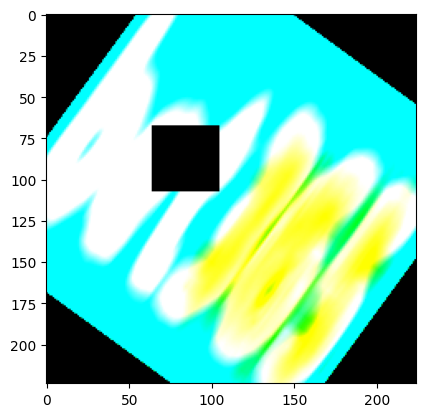

In [7]:
anchor_img, label = train_data[100] # image at index = 100
img_np = anchor_img.numpy()
img_np = np.transpose(img_np, (1,2,0))

plt.imshow(img_np)
plt.show()

In [8]:
batch_size =  32 # Batch = 32 là max khi train với colab và kaggle, nếu lớn hơn thì out of memory -- Vram có 16gb thôi
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers = os.cpu_count()
                          )

In [9]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1.0)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # optional class weights
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.long()
        ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt = softmax(logits)[target]
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


# Resnet18

In [11]:
import torch
import torch.nn as nn
from torchvision import models

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.resnet18(pretrained=True)  
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)           # [B, 512, 1, 1]
        x = torch.flatten(x, 1)        # [B, 512]
        x = self.fc(x)                 # [B, emb_dim]
        return x


In [12]:
model = Network(256).to(device)
x = torch.rand([32, 3, 224, 224]).to(device) # input random
output = model(x)
print(output.shape) # output is torch.Size([32, 256]) -> good

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


torch.Size([32, 256])


In [13]:
num_classes = 135
embedding_dims = 256 #
model = Network(embedding_dims).to(device)
# criterion = SupervisedContrastiveLoss(temperature=0.1).to(device) 
arc_margin = ArcMarginProduct(in_features=256, out_features=num_classes).to(device)
focal_loss = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def TEST(folder_path, model, transforms, key):

    label_org = []
    dir_org = []
    label_test = []
    dir_test_path = []
    dir_org_path = []
    REFER_DICT = {}

    # Put the model in evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over each subfolder in the folder_path
        for label_index, subfolder_name in enumerate(os.listdir(folder_path)):
            REFER_DICT[label_index] = subfolder_name
            subfolder_path = os.path.join(folder_path, subfolder_name)
            image_files = os.listdir(subfolder_path)
            for image_index, image_file in enumerate(image_files):

                image_path = os.path.join(subfolder_path, image_file)

                if key in image_path:

                    image = Image.open(image_path).convert('RGB')
                    image = transforms(image=np.array(image))["image"]
                    # Extract the embedding for the first image in the folder
                    embedding = model(image.unsqueeze(0).to("cuda"))
                    dir_org.append(embedding)
                    label_org.append(label_index)
                    dir_org_path.append(image_path)
                else:
                    # Store the path and label for other images
                    dir_test_path.append(image_path)
                    label_test.append(label_index)

        predict_label = []
        Max_sim = []

        # Iterate over test images
        for test_image_path in dir_test_path:

            test_image = Image.open(test_image_path).convert('RGB')
            test_image = transforms(image=np.array(test_image))["image"]

            # Extract the embedding for the test image
            test_embedding = model(test_image.unsqueeze(0).to("cuda"))
            similarities = []

            # Calculate cosine similarity with each original embedding
            for org_embedding in dir_org:

                cosine_sim = cosine_similarity(org_embedding.cpu().detach().numpy(), test_embedding.cpu().detach().numpy())
                similarities.append(cosine_sim[0][0])
            Max_sim.append(max(similarities))
            max_similarity_index = np.argmax(similarities)

            predict_label.append(label_org[max_similarity_index])

        accuracy = accuracy_score(predict_label, label_test)


        
        print(f'----Accuracy: {accuracy:.4f}')
        print()

        return accuracy

preprocess = A.Compose([
        A.Resize(224, 224),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)

In [15]:
import csv
import os

epochs = 100
model.train()
scaler = torch.amp.GradScaler()

ACC = 0
log_file = "train_ArcFace_Resnet50_log.csv"
model_save_dir = "saved_ArcFace_Resnet50_models"
os.makedirs(model_save_dir, exist_ok=True)

# Khởi tạo file CSV nếu chưa có
if not os.path.exists(log_file):
    with open(log_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Loss', 'Accuracy'])

for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, label) in enumerate(train_loader):
        anchor_img = anchor_img.to(device).float()
        label = label.to(device).long()  # đảm bảo đúng dtype

        with torch.amp.autocast('cuda', enabled=True):
            outputs = model(anchor_img)
            logits = arc_margin(outputs, label)
            loss = focal_loss(logits, label)

        scaler.scale(loss).backward()

        if (step + 1) % 4 == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        running_loss.append(loss.cpu().detach().numpy())

    avg_loss = np.mean(running_loss)

    # Tính accuracy mỗi 10 epoch
    if (epoch + 1) % 10 == 0:
        test_path = "/kaggle/input/logo-verify-test/logo_verify_test"  # đường dẫn test
        accuracy = TEST(test_path, model, preprocess, key="000000")
        model.train()  # quay lại train mode

        # Lưu model nếu tốt nhất
        if accuracy >= ACC:
            best_path = f"/kaggle/working/model_best{accuracy*1000:.0f}.pth"
            torch.save(model, best_path)
            ACC = accuracy
    else:
        accuracy = None  # không test

    # Ghi log CSV
    with open(log_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_loss, accuracy if accuracy is not None else ""])

    # Lưu model mỗi 5 epoch
    if (epoch + 1) % 10 == 0:
        torch.save(model, f"{model_save_dir}/model_epoch_{epoch + 1}.pth")

    print(f"Epoch: {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy}")


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epochs:   1%|          | 1/100 [06:08<10:07:32, 368.20s/it]

Epoch: 1/100 - Loss: 35.2915 - Accuracy: None


Epochs:   2%|▏         | 2/100 [10:53<8:41:56, 319.56s/it] 

Epoch: 2/100 - Loss: 28.9675 - Accuracy: None


Epochs:   3%|▎         | 3/100 [15:15<7:53:41, 293.01s/it]

Epoch: 3/100 - Loss: 23.2974 - Accuracy: None


Epochs:   4%|▍         | 4/100 [19:35<7:28:05, 280.06s/it]

Epoch: 4/100 - Loss: 19.2138 - Accuracy: None


Epochs:   5%|▌         | 5/100 [23:56<7:12:24, 273.10s/it]

Epoch: 5/100 - Loss: 16.3192 - Accuracy: None


Epochs:   6%|▌         | 6/100 [28:16<7:01:07, 268.80s/it]

Epoch: 6/100 - Loss: 14.1233 - Accuracy: None


Epochs:   7%|▋         | 7/100 [32:37<6:52:45, 266.29s/it]

Epoch: 7/100 - Loss: 12.3896 - Accuracy: None


Epochs:   8%|▊         | 8/100 [36:50<6:41:57, 262.15s/it]

Epoch: 8/100 - Loss: 11.0296 - Accuracy: None


Epochs:   9%|▉         | 9/100 [41:08<6:35:31, 260.78s/it]

Epoch: 9/100 - Loss: 9.8949 - Accuracy: None


Epochs:  10%|█         | 10/100 [45:45<6:38:42, 265.80s/it]

----Accuracy: 0.7694

Epoch: 10/100 - Loss: 8.9588 - Accuracy: 0.7693522906793049


Epochs:  11%|█         | 11/100 [50:01<6:29:52, 262.83s/it]

Epoch: 11/100 - Loss: 8.2193 - Accuracy: None


Epochs:  12%|█▏        | 12/100 [54:18<6:22:52, 261.06s/it]

Epoch: 12/100 - Loss: 7.5177 - Accuracy: None


Epochs:  13%|█▎        | 13/100 [58:52<6:23:51, 264.73s/it]

Epoch: 13/100 - Loss: 6.9612 - Accuracy: None


Epochs:  14%|█▍        | 14/100 [1:03:10<6:16:54, 262.97s/it]

Epoch: 14/100 - Loss: 6.4374 - Accuracy: None


Epochs:  15%|█▌        | 15/100 [1:07:30<6:11:07, 261.97s/it]

Epoch: 15/100 - Loss: 5.9903 - Accuracy: None


Epochs:  16%|█▌        | 16/100 [1:11:48<6:04:58, 260.70s/it]

Epoch: 16/100 - Loss: 5.6218 - Accuracy: None


Epochs:  17%|█▋        | 17/100 [1:16:06<5:59:25, 259.82s/it]

Epoch: 17/100 - Loss: 5.2284 - Accuracy: None


Epochs:  18%|█▊        | 18/100 [1:20:22<5:53:48, 258.88s/it]

Epoch: 18/100 - Loss: 4.8925 - Accuracy: None


Epochs:  19%|█▉        | 19/100 [1:24:41<5:49:32, 258.92s/it]

Epoch: 19/100 - Loss: 4.6133 - Accuracy: None


Epochs:  20%|██        | 20/100 [1:29:15<5:50:58, 263.23s/it]

----Accuracy: 0.7773

Epoch: 20/100 - Loss: 4.3717 - Accuracy: 0.7772511848341233


Epochs:  21%|██        | 21/100 [1:33:41<5:47:54, 264.24s/it]

Epoch: 21/100 - Loss: 4.1356 - Accuracy: None


Epochs:  22%|██▏       | 22/100 [1:38:17<5:48:10, 267.82s/it]

Epoch: 22/100 - Loss: 3.9109 - Accuracy: None


Epochs:  23%|██▎       | 23/100 [1:42:51<5:46:06, 269.70s/it]

Epoch: 23/100 - Loss: 3.6928 - Accuracy: None


Epochs:  24%|██▍       | 24/100 [1:47:09<5:37:08, 266.17s/it]

Epoch: 24/100 - Loss: 3.5101 - Accuracy: None


Epochs:  25%|██▌       | 25/100 [1:51:24<5:28:29, 262.80s/it]

Epoch: 25/100 - Loss: 3.3453 - Accuracy: None


Epochs:  26%|██▌       | 26/100 [1:55:33<5:18:53, 258.56s/it]

Epoch: 26/100 - Loss: 3.1773 - Accuracy: None


Epochs:  27%|██▋       | 27/100 [1:59:52<5:14:48, 258.74s/it]

Epoch: 27/100 - Loss: 3.0238 - Accuracy: None


Epochs:  28%|██▊       | 28/100 [2:04:17<5:12:48, 260.67s/it]

Epoch: 28/100 - Loss: 2.8889 - Accuracy: None


Epochs:  29%|██▉       | 29/100 [2:08:34<5:06:55, 259.37s/it]

Epoch: 29/100 - Loss: 2.7517 - Accuracy: None


Epochs:  30%|███       | 30/100 [2:13:03<5:06:07, 262.39s/it]

----Accuracy: 0.7773

Epoch: 30/100 - Loss: 2.6448 - Accuracy: 0.7772511848341233


Epochs:  31%|███       | 31/100 [2:17:16<4:58:29, 259.56s/it]

Epoch: 31/100 - Loss: 2.5393 - Accuracy: None


Epochs:  32%|███▏      | 32/100 [2:21:36<4:54:07, 259.53s/it]

Epoch: 32/100 - Loss: 2.4264 - Accuracy: None


Epochs:  33%|███▎      | 33/100 [2:26:08<4:54:03, 263.34s/it]

Epoch: 33/100 - Loss: 2.3076 - Accuracy: None


Epochs:  34%|███▍      | 34/100 [2:30:38<4:51:49, 265.30s/it]

Epoch: 34/100 - Loss: 2.2237 - Accuracy: None


Epochs:  35%|███▌      | 35/100 [2:35:03<4:47:21, 265.26s/it]

Epoch: 35/100 - Loss: 2.1341 - Accuracy: None


Epochs:  36%|███▌      | 36/100 [2:39:14<4:38:31, 261.12s/it]

Epoch: 36/100 - Loss: 2.0459 - Accuracy: None


Epochs:  37%|███▋      | 37/100 [2:43:32<4:33:03, 260.05s/it]

Epoch: 37/100 - Loss: 1.9427 - Accuracy: None


Epochs:  38%|███▊      | 38/100 [2:47:48<4:27:37, 258.99s/it]

Epoch: 38/100 - Loss: 1.8953 - Accuracy: None


Epochs:  39%|███▉      | 39/100 [2:52:07<4:23:07, 258.81s/it]

Epoch: 39/100 - Loss: 1.8309 - Accuracy: None


Epochs:  40%|████      | 40/100 [2:56:37<4:22:22, 262.37s/it]

----Accuracy: 0.7630

Epoch: 40/100 - Loss: 1.7534 - Accuracy: 0.7630331753554502


Epochs:  41%|████      | 41/100 [3:00:56<4:16:45, 261.11s/it]

Epoch: 41/100 - Loss: 1.6814 - Accuracy: None


Epochs:  42%|████▏     | 42/100 [3:05:16<4:12:19, 261.02s/it]

Epoch: 42/100 - Loss: 1.6217 - Accuracy: None


Epochs:  43%|████▎     | 43/100 [3:09:35<4:07:25, 260.45s/it]

Epoch: 43/100 - Loss: 1.5578 - Accuracy: None


Epochs:  44%|████▍     | 44/100 [3:13:50<4:01:20, 258.57s/it]

Epoch: 44/100 - Loss: 1.4965 - Accuracy: None


Epochs:  45%|████▌     | 45/100 [3:18:08<3:56:50, 258.37s/it]

Epoch: 45/100 - Loss: 1.4457 - Accuracy: None


Epochs:  46%|████▌     | 46/100 [3:22:26<3:52:31, 258.36s/it]

Epoch: 46/100 - Loss: 1.4051 - Accuracy: None


Epochs:  47%|████▋     | 47/100 [3:26:45<3:48:30, 258.70s/it]

Epoch: 47/100 - Loss: 1.3407 - Accuracy: None


Epochs:  48%|████▊     | 48/100 [3:31:04<3:44:14, 258.74s/it]

Epoch: 48/100 - Loss: 1.3018 - Accuracy: None


Epochs:  49%|████▉     | 49/100 [3:35:29<3:41:35, 260.69s/it]

Epoch: 49/100 - Loss: 1.2574 - Accuracy: None


Epochs:  50%|█████     | 50/100 [3:40:08<3:41:35, 265.92s/it]

----Accuracy: 0.7488

Epoch: 50/100 - Loss: 1.2152 - Accuracy: 0.7488151658767772


Epochs:  51%|█████     | 51/100 [3:44:31<3:36:26, 265.04s/it]

Epoch: 51/100 - Loss: 1.1920 - Accuracy: None


Epochs:  52%|█████▏    | 52/100 [3:48:55<3:31:47, 264.73s/it]

Epoch: 52/100 - Loss: 1.1414 - Accuracy: None


Epochs:  53%|█████▎    | 53/100 [3:53:14<3:26:02, 263.03s/it]

Epoch: 53/100 - Loss: 1.1006 - Accuracy: None


Epochs:  54%|█████▍    | 54/100 [3:57:36<3:21:31, 262.86s/it]

Epoch: 54/100 - Loss: 1.0684 - Accuracy: None


Epochs:  55%|█████▌    | 55/100 [4:02:00<3:17:26, 263.26s/it]

Epoch: 55/100 - Loss: 1.0267 - Accuracy: None


Epochs:  56%|█████▌    | 56/100 [4:06:23<3:12:55, 263.09s/it]

Epoch: 56/100 - Loss: 0.9784 - Accuracy: None


Epochs:  57%|█████▋    | 57/100 [4:10:50<3:09:17, 264.13s/it]

Epoch: 57/100 - Loss: 0.9631 - Accuracy: None


Epochs:  58%|█████▊    | 58/100 [4:15:14<3:05:03, 264.37s/it]

Epoch: 58/100 - Loss: 0.9341 - Accuracy: None


Epochs:  59%|█████▉    | 59/100 [4:19:40<3:00:51, 264.67s/it]

Epoch: 59/100 - Loss: 0.8953 - Accuracy: None


Epochs:  60%|██████    | 60/100 [4:24:18<2:59:05, 268.64s/it]

----Accuracy: 0.7409

Epoch: 60/100 - Loss: 0.8678 - Accuracy: 0.740916271721959


Epochs:  61%|██████    | 61/100 [4:28:41<2:53:32, 266.99s/it]

Epoch: 61/100 - Loss: 0.8439 - Accuracy: None


Epochs:  62%|██████▏   | 62/100 [4:33:06<2:48:47, 266.51s/it]

Epoch: 62/100 - Loss: 0.8071 - Accuracy: None


Epochs:  63%|██████▎   | 63/100 [4:37:30<2:43:49, 265.66s/it]

Epoch: 63/100 - Loss: 0.7893 - Accuracy: None


Epochs:  64%|██████▍   | 64/100 [4:41:55<2:39:18, 265.50s/it]

Epoch: 64/100 - Loss: 0.7756 - Accuracy: None


Epochs:  65%|██████▌   | 65/100 [4:46:21<2:34:54, 265.55s/it]

Epoch: 65/100 - Loss: 0.7376 - Accuracy: None


Epochs:  66%|██████▌   | 66/100 [4:50:46<2:30:26, 265.49s/it]

Epoch: 66/100 - Loss: 0.7231 - Accuracy: None


Epochs:  67%|██████▋   | 67/100 [4:55:11<2:25:55, 265.30s/it]

Epoch: 67/100 - Loss: 0.6955 - Accuracy: None


Epochs:  68%|██████▊   | 68/100 [4:59:34<2:21:12, 264.75s/it]

Epoch: 68/100 - Loss: 0.6723 - Accuracy: None


Epochs:  69%|██████▉   | 69/100 [5:04:00<2:16:51, 264.88s/it]

Epoch: 69/100 - Loss: 0.6615 - Accuracy: None


Epochs:  70%|███████   | 70/100 [5:08:38<2:14:30, 269.02s/it]

----Accuracy: 0.7441

Epoch: 70/100 - Loss: 0.6415 - Accuracy: 0.7440758293838863


Epochs:  71%|███████   | 71/100 [5:13:01<2:09:05, 267.07s/it]

Epoch: 71/100 - Loss: 0.6279 - Accuracy: None


Epochs:  72%|███████▏  | 72/100 [5:17:26<2:04:21, 266.49s/it]

Epoch: 72/100 - Loss: 0.5920 - Accuracy: None


Epochs:  73%|███████▎  | 73/100 [5:21:50<1:59:38, 265.87s/it]

Epoch: 73/100 - Loss: 0.5890 - Accuracy: None


Epochs:  74%|███████▍  | 74/100 [5:26:21<1:55:49, 267.29s/it]

Epoch: 74/100 - Loss: 0.5695 - Accuracy: None


Epochs:  75%|███████▌  | 75/100 [5:30:45<1:50:55, 266.23s/it]

Epoch: 75/100 - Loss: 0.5492 - Accuracy: None


Epochs:  76%|███████▌  | 76/100 [5:35:12<1:46:34, 266.44s/it]

Epoch: 76/100 - Loss: 0.5269 - Accuracy: None


Epochs:  77%|███████▋  | 77/100 [5:39:37<1:42:01, 266.16s/it]

Epoch: 77/100 - Loss: 0.5219 - Accuracy: None


Epochs:  78%|███████▊  | 78/100 [5:43:58<1:36:59, 264.51s/it]

Epoch: 78/100 - Loss: 0.5089 - Accuracy: None


Epochs:  79%|███████▉  | 79/100 [5:48:11<1:31:26, 261.25s/it]

Epoch: 79/100 - Loss: 0.4927 - Accuracy: None


Epochs:  80%|████████  | 80/100 [5:52:40<1:27:49, 263.48s/it]

----Accuracy: 0.7188

Epoch: 80/100 - Loss: 0.4835 - Accuracy: 0.7187993680884676


Epochs:  81%|████████  | 81/100 [5:57:09<1:23:56, 265.07s/it]

Epoch: 81/100 - Loss: 0.4630 - Accuracy: None


Epochs:  82%|████████▏ | 82/100 [6:01:51<1:21:00, 270.05s/it]

Epoch: 82/100 - Loss: 0.4452 - Accuracy: None


Epochs:  83%|████████▎ | 83/100 [6:06:34<1:17:37, 273.96s/it]

Epoch: 83/100 - Loss: 0.4413 - Accuracy: None


Epochs:  84%|████████▍ | 84/100 [6:10:58<1:12:18, 271.13s/it]

Epoch: 84/100 - Loss: 0.4182 - Accuracy: None


Epochs:  85%|████████▌ | 85/100 [6:15:20<1:07:07, 268.47s/it]

Epoch: 85/100 - Loss: 0.4098 - Accuracy: None


Epochs:  86%|████████▌ | 86/100 [6:19:42<1:02:11, 266.53s/it]

Epoch: 86/100 - Loss: 0.4084 - Accuracy: None


Epochs:  87%|████████▋ | 87/100 [6:24:03<57:20, 264.67s/it]  

Epoch: 87/100 - Loss: 0.4083 - Accuracy: None


Epochs:  88%|████████▊ | 88/100 [6:28:24<52:43, 263.59s/it]

Epoch: 88/100 - Loss: 0.3776 - Accuracy: None


Epochs:  89%|████████▉ | 89/100 [6:33:00<49:00, 267.30s/it]

Epoch: 89/100 - Loss: 0.3721 - Accuracy: None


Epochs:  90%|█████████ | 90/100 [6:37:38<45:06, 270.68s/it]

----Accuracy: 0.7141

Epoch: 90/100 - Loss: 0.3601 - Accuracy: 0.7140600315955766


Epochs:  91%|█████████ | 91/100 [6:42:08<40:32, 270.23s/it]

Epoch: 91/100 - Loss: 0.3599 - Accuracy: None


Epochs:  92%|█████████▏| 92/100 [6:46:34<35:51, 268.94s/it]

Epoch: 92/100 - Loss: 0.3362 - Accuracy: None


Epochs:  93%|█████████▎| 93/100 [6:51:00<31:16, 268.06s/it]

Epoch: 93/100 - Loss: 0.3313 - Accuracy: None


Epochs:  94%|█████████▍| 94/100 [6:55:24<26:41, 266.93s/it]

Epoch: 94/100 - Loss: 0.3339 - Accuracy: None


Epochs:  95%|█████████▌| 95/100 [6:59:51<22:15, 267.03s/it]

Epoch: 95/100 - Loss: 0.3189 - Accuracy: None


Epochs:  96%|█████████▌| 96/100 [7:04:15<17:44, 266.19s/it]

Epoch: 96/100 - Loss: 0.3076 - Accuracy: None


Epochs:  97%|█████████▋| 97/100 [7:08:43<13:19, 266.58s/it]

Epoch: 97/100 - Loss: 0.3192 - Accuracy: None


Epochs:  98%|█████████▊| 98/100 [7:13:12<08:54, 267.39s/it]

Epoch: 98/100 - Loss: 0.3027 - Accuracy: None


Epochs:  99%|█████████▉| 99/100 [7:17:38<04:26, 266.99s/it]

Epoch: 99/100 - Loss: 0.2817 - Accuracy: None


Epochs: 100%|██████████| 100/100 [7:22:19<00:00, 265.39s/it]

----Accuracy: 0.7062

Epoch: 100/100 - Loss: 0.2907 - Accuracy: 0.7061611374407583
